In [1]:
# install kaggle and unzip
!pip install -q kaggle
!apt-get install -qq unzip

# move kaggle.json into place (you uploaded it via Colab Files panel)
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp /content/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# download and unzip dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud -p /content
!unzip -q /content/creditcardfraud.zip -d /content
print("Dataset downloaded and unzipped to /content/creditcard.csv")


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.08GB/s]
Dataset downloaded and unzipped to /content/creditcard.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for saving files
import os


In [3]:
csv_path = "/content/creditcard.csv"
df = pd.read_csv(csv_path)
print("Loaded:", csv_path)
print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nClass counts:\n", df['Class'].value_counts())


Loaded: /content/creditcard.csv
Shape: (284807, 31)

Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64


After dropna shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


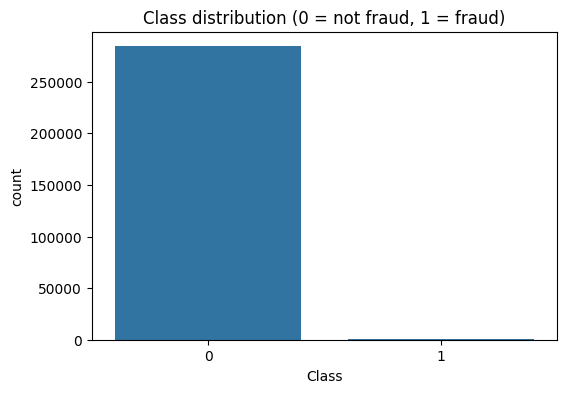

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
df = df.dropna().reset_index(drop=True)
print("After dropna shape:", df.shape)
print(df['Class'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class distribution (0 = not fraud, 1 = fraud)')
plt.show()

display(df.describe())


In [5]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'], axis=1, inplace=True)
df.rename(columns={'scaled_amount':'Amount', 'scaled_time':'Time'}, inplace=True)
df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount,Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

minority_count = y.value_counts().min()
k_neighbors = 5
if minority_count <= 5:
    k_neighbors = max(1, minority_count - 1)  # fallback for very small minority
    print("Very small minority class; using k_neighbors =", k_neighbors)

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_res, y_res = smote.fit_resample(X, y)
print("After SMOTE distribution:\n", pd.Series(y_res).value_counts())


After SMOTE distribution:
 Class
0    284315
1    284315
Name: count, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.25, stratify=y_res, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (426472, 30) Test shape: (142158, 30)


In [8]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:,1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     71079
           1       0.97      0.92      0.95     71079

    accuracy                           0.95    142158
   macro avg       0.95      0.95      0.95    142158
weighted avg       0.95      0.95      0.95    142158

ROC AUC: 0.9893684463638595


In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       1.00      1.00      1.00     71079

    accuracy                           1.00    142158
   macro avg       1.00      1.00      1.00    142158
weighted avg       1.00      1.00      1.00    142158

ROC AUC: 0.9999997243788213


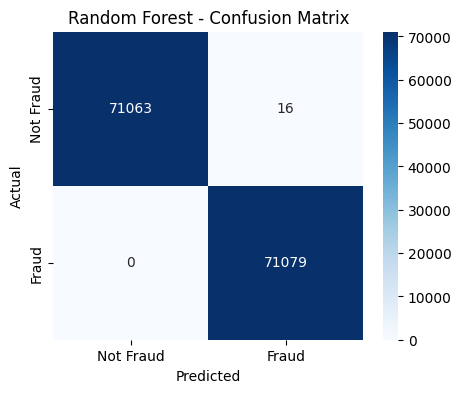

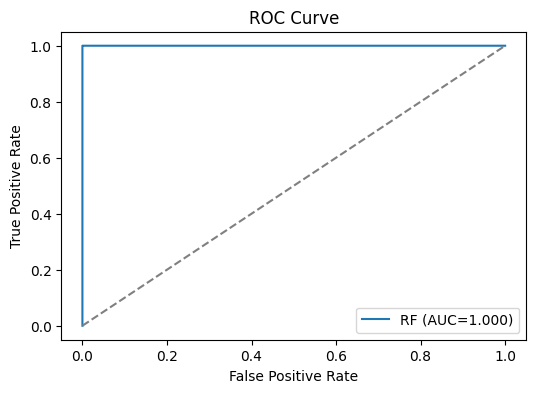

In [12]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Random Forest - Confusion Matrix')
plt.savefig('confusion_matrix_rf.png', bbox_inches='tight')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'RF (AUC={roc_auc_score(y_test,y_prob_rf):.3f})')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend()
plt.savefig('roc_curve_rf.png', bbox_inches='tight')
plt.show()


In [13]:
sample = df.sample(500, random_state=42)  # 500-row sample
sample.to_csv('creditcard_sample.csv', index=False)
print("Saved creditcard_sample.csv (500 rows)")


Saved creditcard_sample.csv (500 rows)


In [14]:
# requirements.txt
reqs = """pandas
numpy
matplotlib
seaborn
scikit-learn
imbalanced-learn
"""
open('requirements.txt','w').write(reqs)

# README.md (ready to paste to GitHub)
readme = """# Credit Card Fraud Detection

**Overview**
Detect fraudulent credit card transactions using ML (Logistic Regression & Random Forest).

**Dataset**
Original dataset (Kaggle): https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
This repo includes a 500-row sample only (`creditcard_sample.csv`). Download the full dataset from Kaggle if you want to run end-to-end.

**How to run**
1. Install: `pip install -r requirements.txt`
2. Open `fraud_detection.ipynb` in Jupyter/Colab and run cells.

**Files**
- `fraud_detection.ipynb` — notebook with full pipeline
- `creditcard_sample.csv` — 500-row sample
- `confusion_matrix_rf.png`, `roc_curve_rf.png` — model visuals

**Author**: Your Name
"""
open('README.md','w').write(readme)
print("requirements.txt and README.md created.")


requirements.txt and README.md created.


In [15]:
# gather files into a folder and zip
!mkdir -p fraud_project
!cp fraud_detection.ipynb fraud_project/ 2>/dev/null || true
!cp requirements.txt fraud_project/
!cp README.md fraud_project/
!cp creditcard_sample.csv fraud_project/
!cp confusion_matrix_rf.png fraud_project/ 2>/dev/null || true
!cp roc_curve_rf.png fraud_project/ 2>/dev/null || true

!zip -r fraud_detection_project.zip fraud_project
print("Created fraud_detection_project.zip")


  adding: fraud_project/ (stored 0%)
  adding: fraud_project/roc_curve_rf.png (deflated 11%)
  adding: fraud_project/creditcard_sample.csv (deflated 54%)
  adding: fraud_project/confusion_matrix_rf.png (deflated 13%)
  adding: fraud_project/README.md (deflated 39%)
  adding: fraud_project/requirements.txt (deflated 10%)
Created fraud_detection_project.zip


In [17]:
from google.colab import files
files.download('fraud_detection_project.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>